In [15]:
import csv
import numpy as np
import tensorflow as tf
import keras
import cv2
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

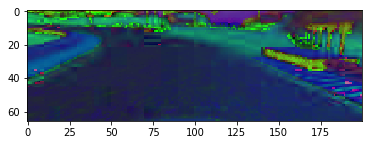

In [16]:
loc = 'data/IMG/center_2016_12_01_13_31_13_786.jpg'
img = cv2.imread(loc)

img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_adjusted = preprocess_img(img_RGB, istraining=True)
# # Convert BGR to HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# # define range of blue color in HSV
# lower_blue = np.array([0,100,100])
# upper_blue = np.array([20,255,255])
# # # Threshold the HSV image to get only blue colors
# mask = cv2.inRange(img_hsv, lower_blue, upper_blue)
# # # Bitwise-AND mask and original image
# res = cv2.bitwise_and(img, img, mask= mask)
img_hsv[:,:,2] += 10
img_distort_RGB = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

plt.imshow(img_adjusted)
plt.show()
# # cv2.imshow('mask',mask)
# cv2.imshow('res',res)
# cv2.waitKey(0) & 0xFF
# cv2.destroyAllWindows()


In [49]:
def preprocess_img(image, resize = (200, 66), istraining = False):
    '''
    Preprocessing consists of four steps in training mode (three in inference mode). 
    step 1: crop the image
    step 2: resize the image 
    step 3: convert the image to HSV
    step 4: randomly adjust the brightness (only in training mode)
    -------
    Params:
    image: RGB image; resize: new size of the image; istraining: boolean used to control the mode
    ------
    return: an resized HSV image (brightness might also be adjusted if in training mode)
    '''
    # Crop the top 50 pixes and bottom 20 pixes to increase the signal noise ratio
    img = image[50:-20, :, :]
    # Resize to 200*66 to comform the Nvidia end to end model input size
    img = cv2.resize(img, resize)
    # Convert to HSV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #In training mode, adjust the brightness randomly by a scaling factor
    if istraining is True:
        v = img[:,:,2].astype(np.float32)
        v *= np.random.choice(np.arange(0.5, 2.0, 0.1))
        img[:,:,2] = v.astype(np.uint8)
    return img

def load_data(data):
    '''
    Get the images and the steering angles. The main algorithm consists of 4 steps. 
    step 1: get the image name from the driving_log file
    step 2: get the image path for further image reading
    step 3: read the image file using cv2 (BGR format) and convert the file to RGB
    step 4: store the images data into a list and the corresponding steering angles into another list
    The images from the middle camera is augmented by flipping, the images from left and right cameras 
    are also used to help recover the car to the lane center if shifted. 
    -------
    Params:
    data: the folder where images and driving_log file are stored
    The the first line of the logfile consists of column names. All the rest lines consist of the locations of images, 
    steering angles, and other data. To load the images and steering angles, the first line is omitted.
    -------
    Return: two lists containing images as inputs and steering angles as outputs
    '''
    images = []
    steers = []
    loc = data + '/driving_log.csv'
    with open(loc) as csvfile:
        reader = csv.reader(csvfile)
        i = 0 # This count is for omitting the first line of the logfile
        for line in reader:
        # Skip the header 
            if i > 0:
                # First, get the image name for the middle, left, right cameras
                path_mid = line[0].split('/')[-1]
                path_left = line[1].split('/')[-1]
                path_right = line[2].split('/')[-1]
                # Second, get the image path
                img_path_mid = data + '/IMG/' + path_mid
                img_path_left = data + '/IMG/' + path_left
                img_path_right = data + '/IMG/' + path_right
                # Third, load the images 
                # cv2 loads images as BGR, convert to RGB
                img = cv2.imread(img_path_mid)[:, :, ::-1]
                img = preprocess_img(img, istraining=True)
                img_left = cv2.imread(img_path_left)[:, :, ::-1]
                img_left = preprocess_img(img_left, istraining=True)
                img_right = cv2.imread(img_path_right)[:, :, ::-1]
                img_right = preprocess_img(img_right, istraining=True)
                # Finally, append all images and corresponding steering angles into lists. 
                # Left and right camera images are there for steering cars to the middle, 0.5 is chosen for correction
                images.append(img)
                steers.append(float(line[3]))
                images.append(img_left)
                steers.append(0.25)
                images.append(img_right)
                steers.append(-0.25)
                # Flip the middle images 
                img2 = np.fliplr(img)
                images.append(img2)
                steers.append(-float(line[3]))
            i += 1
    return images, steers

In [50]:
# shuffle the images and split into training and validation sets
def train_valid_split(images, steers, valid_size = 0.05):
    ind = np.arange(len(images))
    np.random.shuffle(ind)
    cutoff = int(len(ind)*(1-valid_size))
    train_ind = ind[:cutoff]
    valid_ind = ind[cutoff:]
    train_images = [images[i] for i in train_ind]
    valid_images = [images[i] for i in valid_ind]
    train_steers = [steers[i] for i in train_ind]
    valid_steers = [steers[i] for i in valid_ind]
    return train_images, train_steers, valid_images, valid_steers
        

# Define a generator for memory saving. Put the generator into a while loop to avoid running out of data during training
def generator_(X, y, batch_size = 64):
    while True:
        X, y = shuffle(X, y, random_state=42)
        for offset in range(0, len(X), batch_size):
            end = offset + batch_size
            X_batch = np.array(X[offset:end])
            y_batch = np.array(y[offset:end])
            yield X_batch, y_batch

In [51]:
def trim_data(images, steers, nb_bins=40, cutoff = None, threshold = None):
    """
    Make the training data distribution less steep by discarding some data
    -----
    Params: 
    nb_bins: the number of bins for counting steers angles
    cutoff: the value threshold, if a steering angle has more samples than it, then remove part of the data
    -----
    Return: trimmed images and steering angles
    """
    hist, bins = np.histogram(steers, bins=np.linspace(np.min(steers),np.max(steers), nb_bins))
    # Find the bins that need to discard some data
    mean, std = np.mean(hist), np.std(hist)
    # If cutoff is not provided, then the cutoff equals the mean plus one std
    if cutoff is None:
        cutoff = mean+std
    bin_ind_to_remove = [i for i in range(len(hist)) if hist[i] > cutoff]
    # If threshold is not provided, then the threshold is the maximum of the residial values
    if threshold is None:
        threshold = np.max([hist[i] for i in range(len(hist)) if i not in bin_ind_to_remove])
    # Calculate the probability to keep for the selected bins. 
    # The prob equals the threshold divided by the real counts of the bin
    keep_prob = [threshold/(hist[i]) for i in bin_ind_to_remove]

    # Create an index for data deletion
    index2delete = []
    for i in range(len(steers)):
        for j in bin_ind_to_remove:
            if steers[i] > bins[j] and steers[i] <= bins[j+1]:
                if np.random.random() > keep_prob[bin_ind_to_remove.index(j)]:
                    index2delete.append(i)
    images = [images[i] for i in range(len(images)) if i not in index2delete]
    steers = [steers[i] for i in range(len(steers)) if i not in index2delete]
#     print('{} hist in {} bins'.format(len(hist), len(bins)))
#     print('')
#     print('The trimmed steering angles are in bins: {}'.format([(bins[i], bins[i+1]) for i in bin_ind_to_remove]),
#           'The respective keep probabilities are: {}'.format(keep_prob))
    return images, steers

In [60]:
# Get the images and steering angle data
images, steers = [], []
for data in ['./data', './data3']:
    image, steer = load_data(data)
    images.extend(image)
    steers.extend(steer)
    

In [61]:
trimmed_images, trimmed_steers = trim_data(images, steers) 

In [69]:
hist, bins = np.histogram(steers, bins=50)
np.mean(hist), np.std(hist)

(1427.28, 4823.7828435368028)

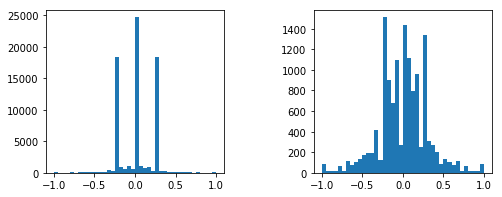

In [63]:
# Visualize the steering angles distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].hist(steers, bins=40)
# axes[0].set_ylim(0, 5000)
axes[1].hist(trimmed_steers,bins=40)
# axes[1].set_ylim(0, 1200)
plt.subplots_adjust(wspace=0.5)

plt.show()
fig.savefig('Data_distribution.png', dpi=300)

In [64]:
len(images), len(trimmed_images)

(71364, 13582)

In [65]:
# Split the data into training and validation sets
train_images, train_steers, valid_images, valid_steers = train_valid_split(trimmed_images, trimmed_steers)

In [66]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Convolution2D, Lambda
from keras.layers import Dropout

In [67]:
# The model is similar with the model from Nvidia paper: Nvidia_X End-to-End Deep Learning for Self-Driving Cars
model = Sequential()

#input image size is 66*200*3
model.add(Lambda(lambda x: x/127.5-1, input_shape=images[0].shape))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), border_mode='valid', activation='elu'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), border_mode='valid', activation='elu'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), border_mode='valid', activation='elu'))
model.add(Convolution2D(64, 3, 3, activation='elu'))
model.add(Convolution2D(64, 3, 3, activation='elu'))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer=keras.optimizers.adam(lr=0.0001))
hist = model.fit_generator(generator_(train_images, train_steers), samples_per_epoch=len(train_images), 
       validation_data = generator_(valid_images, valid_steers), nb_val_samples = len(valid_images), nb_epoch=10)
model.save('model.h5')
with open('./model.json' ,'w') as f:
    f.write(model.to_json())

Epoch 1/10
12902/12902 [==============================] - 11s - loss: 0.1013 - val_loss: 0.0494
Epoch 2/10
12902/12902 [==============================] - 11s - loss: 0.0696 - val_loss: 0.0465
Epoch 3/10
12902/12902 [==============================] - 11s - loss: 0.0621 - val_loss: 0.0457
Epoch 4/10
12902/12902 [==============================] - 11s - loss: 0.0575 - val_loss: 0.0423
Epoch 5/10
12902/12902 [==============================] - 11s - loss: 0.0535 - val_loss: 0.0425
Epoch 6/10
12902/12902 [==============================] - 11s - loss: 0.0526 - val_loss: 0.0444
Epoch 7/10
12902/12902 [==============================] - 11s - loss: 0.0502 - val_loss: 0.0414
Epoch 8/10
12902/12902 [==============================] - 11s - loss: 0.0483 - val_loss: 0.0438
Epoch 9/10
12902/12902 [==============================] - 11s - loss: 0.0479 - val_loss: 0.0442
Epoch 10/10
12902/12902 [==============================] - 11s - loss: 0.0462 - val_loss: 0.0420
